<a href="https://colab.research.google.com/github/frapasti/Embedded-Person-detection/blob/main/Stat_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fiftyone --no-binary fiftyone,voxel51-eta
import fiftyone as fo
import fiftyone.zoo as foz
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle
import json
import cv2
import imutils
from google.colab.patches import cv2_imshow

# DATASET IMPORTING

Import a dataset of 500 images containing persons from the coco validation split, then download 78 images more from the coco dataset without any person. 

In [2]:
import fiftyone.zoo as foz

#DATASET containing persons
dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["detections"],
    classes=["person"],
    only_matching = True,
    max_samples=500,
)

 100% |██████|    1.9Gb/1.9Gb [2.5s elapsed, 0s remaining, 739.2Mb/s]       
Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_val2017.json'
 100% |██████████████████| 500/500 [43.1s elapsed, 0s remaining, 11.3 images/s]      
Writing annotations for 500 downloaded samples to '/root/fiftyone/coco-2017/validation/labels.json'
Dataset info written to '/root/fiftyone/coco-2017/info.json'
Loading 'coco-2017' split 'validation'
 100% |█████████████████| 500/500 [1.9s elapsed, 0s remaining, 272.4 samples/s]      
Dataset 'coco-2017-validation-500' created


In order to download images containg non person it's necessary to use the launch app view of fiftyone and label all the downloaded samples containg persons with "remove". 
In this way samples with such label will be effectively removed from the dataset

In [ ]:
#DATASET of non persons
dataset1 = foz.load_zoo_dataset(
    "coco-2017",
    split="train",
    label_types=["detections"],
    only_matching = True,
    max_samples=150,
)

from fiftyone import ViewField as F
class_name = "Person"

# Find samples that have a "Person"
pos_view = dataset1.filter_labels("ground_truth", F("label")==class_name)

# Find all samples without a positively labeled "Person"
neg_view = dataset1.exclude(pos_view)

# Tag any samples that have a person in the App with "remove"
session = fo.launch_app(view=neg_view)

In [4]:
# Find and remove all tagged samples from the DatasetView
neg_view = neg_view.match_tags("remove", bool=False)

neg_view.export(
    export_dir="/content/nonPerson1",
    dataset_type=fo.types.COCODetectionDataset,
)

 100% |███████████████████| 78/78 [302.5ms elapsed, 0s remaining, 257.8 samples/s]      


# **DATA ORGANIZATION**

  Now extract the paths of the images that have been downloaded and save them in a list called "**every_path**"

  For each image count the number of persons that are present and return the number in the list "**counters**"

  For each image append the ground truth boxes in the list "**bboxes**"


In [5]:
f = open('/root/fiftyone/coco-2017/validation/labels.json')
data = json.load(f)
annotations = data['annotations']
every_path = []
cols = 10
rows = 578
bbox_size = 4
counters = [0] * rows
bboxes = [[] for i in range(rows)] 
items = 0
# Creation of the list of paths of images in the dataset and bboxes
# This elements are extracted from the json file downloaded from coco with the dataset
for entry in data['annotations']:
    class_id = entry['category_id']
    if (class_id == 1):
        img_id = entry['image_id']
        path = float(img_id)/pow(10,11)
        dec_path = format(path, '.11f')
        final_path = ''
        final_path = '/root/fiftyone/coco-2017/validation/data/'+ dec_path.replace('.', '') + '.jpg'
        if(every_path.count(final_path) == 0):
          every_path.append(final_path)
          bboxes[items].append(entry['bbox'])
          items = items + 1
        else:
          index = every_path.index(final_path)
          if(counters[index] + 1 < 10):
            bboxes[index].append(entry['bbox'])
            counters[index] = counters[index] + 1

import os

def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

#attach to every path the paths of the images containg non persons 
every_path.extend(listdir_fullpath("/content/nonPerson1/data"))

Function to calculate the Intersection Over Union of a ground box and a predicted box

In [6]:
def calc_iou( gt_bbox, pred_bbox):
    '''
    This function takes the predicted bounding box and ground truth bounding box and 
    return the IoU ratio
    '''
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt= gt_bbox[0] , gt_bbox[1], gt_bbox[0] + gt_bbox[2] , gt_bbox[1] + gt_bbox[3]
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p= pred_bbox[0] , pred_bbox[1], pred_bbox[0] + pred_bbox[2] , pred_bbox[1] + pred_bbox[3]
    
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt> y_bottomright_gt):
        raise AssertionError("Ground Truth Bounding Box is not correct")
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p> y_bottomright_p):
        raise AssertionError("Predicted Bounding Box is not correct",x_topleft_p, x_bottomright_p,y_topleft_p,y_bottomright_gt)
        
         
    #if the GT bbox and predcited BBox do not overlap then iou=0
    if(x_bottomright_gt< x_topleft_p):
        # If bottom right of x-coordinate  GT  bbox is less than or above the top left of x coordinate of  the predicted BBox
        
        return 0.0
    if(y_bottomright_gt< y_topleft_p):  # If bottom right of y-coordinate  GT  bbox is less than or above the top left of y coordinate of  the predicted BBox
        
        return 0.0
    if(x_topleft_gt> x_bottomright_p): # If bottom right of x-coordinate  GT  bbox is greater than or below the bottom right  of x coordinate of  the predcited BBox
        
        return 0.0
    if(y_topleft_gt> y_bottomright_p): # If bottom right of y-coordinate  GT  bbox is greater than or below the bottom right  of y coordinate of  the predcited BBox
        
        return 0.0
    
    
    GT_bbox_area = (x_bottomright_gt -  x_topleft_gt + 1) * (  y_bottomright_gt -y_topleft_gt + 1)
    Pred_bbox_area =(x_bottomright_p - x_topleft_p + 1 ) * ( y_bottomright_p -y_topleft_p + 1)
    
    x_top_left =np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
    
    intersection_area = (x_bottom_right- x_top_left + 1) * (y_bottom_right-y_top_left  + 1)
    
    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
   
    return intersection_area/union_area

In [7]:
def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xlest, yleft, width, height]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """
    
    if len(gt_boxes)==0:
        tp=0
        fp=len(pred_boxes)
        fn=0
        return [tp, fp, fn]
    
    if len(pred_boxes)==0 & len(gt_boxes) != 0:
        tp=0
        fp=0
        fn=len(gt_boxes)
        return [tp, fp, fn]

    if len(pred_boxes)==0 & len(gt_boxes) == 0:
        tp=0
        fp=0
        fn=len(gt_boxes)
        return [tp, fp, fn]
    
    tp = 0
    for i in range(0, len(gt_boxes)):
      for h in range(0, len(pred_boxes)):
        if(calc_iou(gt_boxes[i],pred_boxes[h]) >= iou_thr):
          if(tp < len(pred_boxes)):
            tp += 1
            break
    fp = len(pred_boxes) - tp
    fn = len(gt_boxes) - tp

    return [tp, fp, fn]

# **HOG EVALUATION**

Exploiting the hog detector provided by OpenCV, this detector returns a list of proposed boxes for an image

In [8]:
def hog_detector(im_path): 
  # Initializing the HOG person
  # detector
  hog = cv2.HOGDescriptor()
  hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
    
  # Reading the Image
  image = cv2.imread(im_path)
    
  # Detecting all the regions in the 
  # Image that have a pedestrians inside it
  (regions, _) = hog.detectMultiScale(image, 
                                      winStride=(4, 4),
                                      padding=(4, 4),
                                      scale=1.05)
    
  # Drawing the regions in the Image
  for (x, y, w, h) in regions:
      cv2.rectangle(image, (x, y), 
                    (x + w, y + h), 
                    (0, 0, 255), 2)
    
  # Showing the output Image
  #cv2_imshow(image)

  return regions

Now for each image in our dataset we calculate the regions proposed by Hog and save them in the list **prop_regions**

In [9]:
prop_regions = []
for i in range(0,578):
  prop_regions.append(hog_detector(every_path[i]))

Finally calcualte the detection rate based on an IOU_threshold, if the IoU threshold is small then more boxes will be considered as correct predictions.

The number of correct predictions will then be compared with the number of supposed predictions, so the number of persons that are supposed to be in the image

The script calculates the detection rate as person detected / total person based on different iou_thresholds

In [10]:
iou_thr = 0
iou_thresholds = []
hog_results = np.zeros((1000,3))
HOG_precision = np.zeros((1000,))
HOG_recall = np.zeros((1000,))
HOG_f1 = np.zeros((1000,))
HOG_missrate = np.zeros((1000,))
for h in range(0,1000):
  iou_thr += 0.001  
  iou_thresholds.append(iou_thr)
  tp = 0
  fp = 0
  fn = 0 
  for i in range(0, 378): #578 originally
    res = get_single_image_results(bboxes[i],prop_regions[i],iou_thr)
    tp += res[0]
    fp += res[1]
    fn += res[2]
  hog_results[h][0] = tp
  hog_results[h][1] = fp
  hog_results[h][2] = fn
  prec = tp / (tp + fp)
  rec = tp / (tp + fn)
  HOG_precision[h] = tp / (tp + fp)
  HOG_recall[h] = tp / (tp + fn)
  if(prec + rec != 0):
    HOG_f1[h] = 2 * (prec * rec)/ (prec + rec)
  HOG_missrate[h] = fn / (tp + fn) 
  

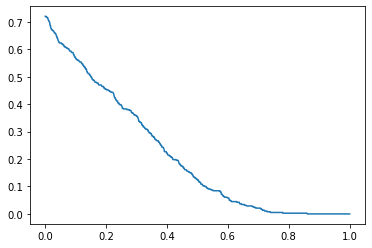

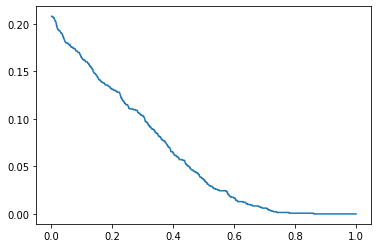

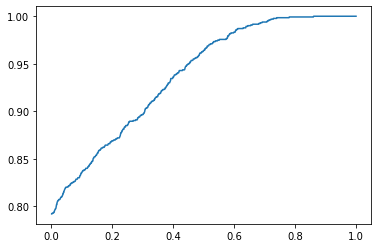

In [12]:
pyplot.plot(iou_thresholds, HOG_precision)
pyplot.show()

pyplot.plot(iou_thresholds, HOG_recall)
pyplot.show()

pyplot.plot(iou_thresholds, HOG_missrate)
pyplot.show()

from scipy.io import savemat

mdic = {"iou_threshold": iou_thresholds}
savemat("/content/HOG_results/iou_thresholds.mat", mdic)

mdic = {"HOG_precision": HOG_precision}
savemat("/content/HOG_results/HOG_precision.mat", mdic)

mdic = {"HOG_recall": HOG_recall}
savemat("/content/HOG_results/HOG_recall.mat", mdic)

mdic = {"HOG_missrate": HOG_missrate}
savemat("/content/HOG_results/HOG_missrate.mat", mdic)

mdic = {"HOG_f1": HOG_f1}
savemat("/content/HOG_results/HOG_f1.mat", mdic)

# **VIOLA AND JONES**

Now do the same type of evaluation for the Viola and Jones method provided by OpenCV

In [ ]:
def viola_detector(im_path): 
    
  #Reading the Image
  image = cv2.imread(im_path)

  #convert in gray_scale since the cascade classifier works on gray_scale images
  grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  #load the cascade classifier, detect the bodies in the image and draw them for the user to see
  body_cascade = cv2.CascadeClassifier('/content/haarcascade_fullbody.xml')
  detected_bodies = body_cascade.detectMultiScale(grayscale_image)
  for (column, row, width, height) in detected_bodies:
      cv2.rectangle(image,(column, row),(column + width, row + height),(0, 255, 0),4)    
  #Showing the output Image
  #cv2_imshow(image)

  return detected_bodies

In [ ]:
prop_regions_viola = []
for i in range(0,578):
  prop_regions_viola.append(viola_detector(every_path[i]))

In [ ]:
iou_thr = 0
iou_thresholds = []
viola_results = np.zeros((1000,3))
viola_precision = np.zeros((1000,))
viola_recall = np.zeros((1000,))
viola_f1 = np.zeros((1000,))
viola_missrate = np.zeros((1000,))
for h in range(0,1000):
  iou_thr += 0.001  
  iou_thresholds.append(iou_thr)
  tp = 0
  fp = 0
  fn = 0 
  for i in range(0, 578):
    res = get_single_image_results(bboxes[i],prop_regions_viola[i],iou_thr)
    tp += res[0]
    fp += res[1]
    fn += res[2]
  viola_results[h][0] = tp
  viola_results[h][1] = fp
  viola_results[h][2] = fn
  prec = tp / (tp + fp)
  rec = tp / (tp + fn)
  viola_precision[h] = tp / (tp + fp)
  viola_recall[h] = tp / (tp + fn)
  if(prec + rec != 0):
    viola_f1[h] = 2 * (prec * rec)/ (prec + rec)
  viola_missrate[h] = fn / (tp + fn) 

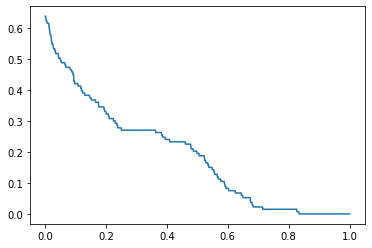

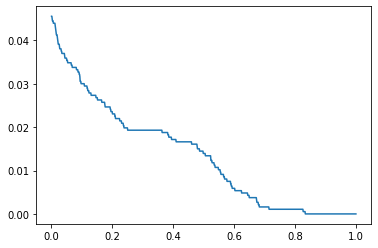

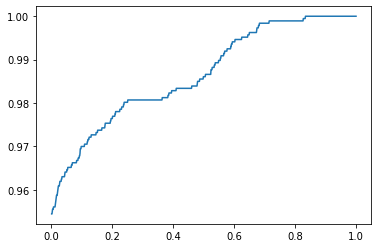

In [ ]:
pyplot.plot(iou_thresholds, viola_precision)
pyplot.show()

pyplot.plot(iou_thresholds, viola_recall)
pyplot.show()

pyplot.plot(iou_thresholds, viola_missrate)
pyplot.show()

from scipy.io import savemat

mdic = {"viola_threshold": iou_thresholds}
savemat("/content/VIOLA_results/iou_thresholds.mat", mdic)

mdic = {"viola_precision": viola_precision}
savemat("/content/VIOLA_results/viola_precision.mat", mdic)

mdic = {"viola_recall": viola_recall}
savemat("/content/VIOLA_results/viola_recall.mat", mdic)

mdic = {"viola_missrate": viola_missrate}
savemat("/content/VIOLA_results/viola_missrate.mat", mdic)

mdic = {"viola_f1": viola_f1}
savemat("/content/VIOLA_results/viola_f1.mat", mdic)

# **Improving Viola**

The same type of test have been done on the Viola and Jones detector and it's clear that it performs much worse, a reason could be that the cascade classifier is only for full bodies, a way to improve this performance could be to also use the haarcascade upper body and haar cascade lower body and see if it works better

In [ ]:
def viola_detector_powered(im_path): 
    
  #Reading the Image
  image = cv2.imread(im_path)

  #convert in gray_scale since the cascade classifier works on gray_scale images
  grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  #load the cascade classifier, detect the bodies in the image and draw them for the user to see
  body_cascade = cv2.CascadeClassifier('/content/haarcascade_fullbody.xml')
  lbody_cascade = cv2.CascadeClassifier('/content/haarcascade_lowerbody.xml') #lower body
  ubody_cascade = cv2.CascadeClassifier('/content/haarcascade_upperbody.xml') #upper body
  
  detected_bodies = body_cascade.detectMultiScale(grayscale_image)
  ldetected_bodies = lbody_cascade.detectMultiScale(grayscale_image) #lower_body
  udetected_bodies = ubody_cascade.detectMultiScale(grayscale_image) #upper_body
  
  tot_bodies = list(detected_bodies) + list(ldetected_bodies) + list(udetected_bodies) #concatenate all the detected bboxes

  for (column, row, width, height) in tot_bodies:
      cv2.rectangle(image,(column, row),(column + width, row + height),(0, 255, 0),4)    
  #Showing the output Image
  #cv2_imshow(image)

  return tot_bodies

NB : Next cell took 7 min 33 seconds!

In [ ]:
prop_regions_viola_powered = []
for i in range(0,578):
  prop_regions_viola_powered.append(viola_detector_powered(every_path[i]))

In [ ]:
iou_thr = 0
iou_thresholds = []
pow_viola_results = np.zeros((1000,3))
pow_viola_precision = np.zeros((1000,))
pow_viola_recall = np.zeros((1000,))
pow_viola_f1 = np.zeros((1000,))
pow_viola_missrate = np.zeros((1000,))
for h in range(0,1000):
  iou_thr += 0.001  
  iou_thresholds.append(iou_thr)
  tp = 0
  fp = 0
  fn = 0 
  for i in range(0, 578):
    res = get_single_image_results(bboxes[i],prop_regions_viola_powered[i],iou_thr)
    tp += res[0]
    fp += res[1]
    fn += res[2]
  pow_viola_results[h][0] = tp
  pow_viola_results[h][1] = fp
  pow_viola_results[h][2] = fn
  prec = tp / (tp + fp)
  rec = tp / (tp + fn)
  pow_viola_precision[h] = tp / (tp + fp)
  pow_viola_recall[h] = tp / (tp + fn)
  if(prec + rec != 0):
    pow_viola_f1[h] = 2 * (prec * rec)/ (prec + rec)
  pow_viola_missrate[h] = fn / (tp + fn) 

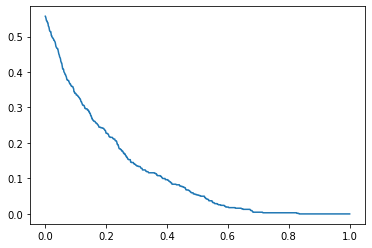

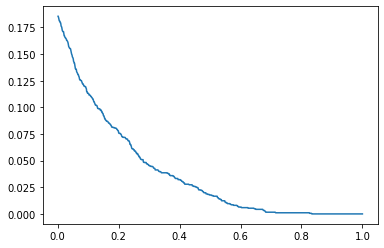

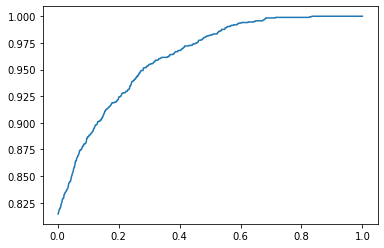

In [ ]:
pyplot.plot(iou_thresholds, pow_viola_precision)
pyplot.show()

pyplot.plot(iou_thresholds, pow_viola_recall)
pyplot.show()

pyplot.plot(iou_thresholds, pow_viola_missrate)
pyplot.show()

from scipy.io import savemat

mdic = {"pow_viola_threshold": iou_thresholds}
savemat("/content/pow_VIOLA_results/iou_thresholds.mat", mdic)

mdic = {"pow_viola_precision": pow_viola_precision}
savemat("/content/pow_VIOLA_results/pow_viola_precision.mat", mdic)

mdic = {"pow_viola_recall": pow_viola_recall}
savemat("/content/pow_VIOLA_results/pow_viola_recall.mat", mdic)

mdic = {"pow_viola_missrate": pow_viola_missrate}
savemat("/content/pow_VIOLA_results/pow_viola_missrate.mat", mdic)

mdic = {"pow_viola_f1": pow_viola_f1}
savemat("/content/pow_VIOLA_results/pow_viola_f1.mat", mdic)

Now it performs much better! However using all this classifier could sensibly decrease the performances

# **YOLO v3**

Do the same type of evaluations on the YOLO v3 model that has been already been trained.
The trained model is able to detect 80 classes! However we are only interested in the person class. So we extract only the predicted bounding boxes associated with that class and perform the needed evaluations 

The weights are downloaded directly by darknet and mounted on the keras sequential yolo model.



In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2022-06-21 11:05:51--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  39.8MB/s    in 6.3s    

2022-06-21 11:05:58 (37.3 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [ ]:
import argparse
import os
import numpy as np
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model
import struct
import cv2
import sys
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle



np.set_printoptions(threshold=sys.maxsize)
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Below there are a number of classes and functions that are needed to execute the yolo network. They have been hidden to have a cleaner notebook

In [ ]:
#@title

def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x


def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)

    model = Model(input_image, [yolo_82, yolo_94, yolo_106])    
    return model

class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,    = struct.unpack('i', w_f.read(4))
            minor,    = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))

            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)

            transpose = (major > 1000) or (minor > 1000)
            
            binary = w_f.read()

        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))

                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))

                    size = np.prod(norm_layer.get_weights()[0].shape)

                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance            

                    weights = norm_layer.set_weights([gamma, beta, mean, var])  

                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))     
    
    def reset(self):
        self.offset = 0

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.objness = objness
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_netout(netout, anchors, obj_thresh, nms_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5

    boxes = []

    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            #objectness = netout[..., :4]
            
            if(objectness.all() <= obj_thresh): continue
            
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]

            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height  
            
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            #box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, None, classes)

            boxes.append(box)

    return boxes

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    if (float(net_w)/image_w) < (float(net_h)/image_h):
        new_w = net_w
        new_h = (image_h*net_w)/image_w
    else:
        new_h = net_w
        new_w = (image_w*net_h)/image_h
        
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)


def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
        
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            if boxes[index_i].classes[c] == 0: continue

            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]

                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0 


# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores


# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# get coordinates
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color='white')
		# draw the box
		ax.add_patch(rect)
		# draw text and score in top left corner
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		pyplot.text(x1, y1, label, color='white')
	# show the plot
	pyplot.show()




In [ ]:
# define the model
model = make_yolov3_model()

# load the model weights
weight_reader = WeightReader('/content/yolov3.weights')
weight_reader.load_weights(model)

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [ ]:
# define the anchors and labels
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
# get the details of the detected objects
# define the probability threshold for detected objects
class_threshold = 0.6

**ATTENTION**: the next cell infers 578 test images throught the network, thus it may take a long time to execute (last execution 59 min 10 s)

In [ ]:
prop_regions_yolo = []
for i in range(0,578):
  # load the image with the required size
  image = load_img(every_path[i], target_size=(416, 416))
  width, height = image.size
  # convert to numpy array
  image = img_to_array(image)
  # scale pixel values to [0, 1]
  image = image.astype('float32')
  image /= 255.0
  image = expand_dims(image, 0)
  # make prediction
  yhat = model.predict(image)
  boxes = list()
  for i in range(len(yhat)):
    # decode the output of the network
    boxes += decode_netout(yhat[i][0], anchors[i], 0.6, class_threshold, 416, 416)
  correct_yolo_boxes(boxes, height, width, 416, 416)
  # suppress non-maximal boxes
  do_nms(boxes, class_threshold)
  # get the details of the detected objects
  v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
  detected_persons = []
  for i in range(len(v_boxes)):
    if v_labels[i] == "person":
      box = v_boxes[i]
      y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
      width_box, height_box = x2 - x1, y2 - y1
      detected_persons.append([x1,y1,width_box,height_box])
  prop_regions_yolo.append(detected_persons)

In [ ]:
iou_thr = 0
iou_thresholds = []
yolo_results = np.zeros((1000,3))
yolo_precision = np.zeros((1000,))
yolo_recall = np.zeros((1000,))
yolo_f1 = np.zeros((1000,))
yolo_missrate = np.zeros((1000,))
for h in range(0,1000):
  iou_thr += 0.001  
  iou_thresholds.append(iou_thr)
  tp = 0
  fp = 0
  fn = 0 
  for i in range(0, 578):
    res = get_single_image_results(bboxes[i],prop_regions_yolo[i],iou_thr)
    tp += res[0]
    fp += res[1]
    fn += res[2]
  yolo_results[h][0] = tp
  yolo_results[h][1] = fp
  yolo_results[h][2] = fn
  prec = tp / (tp + fp)
  rec = tp / (tp + fn)
  yolo_precision[h] = tp / (tp + fp)
  yolo_recall[h] = tp / (tp + fn)
  if(prec + rec != 0):
    yolo_f1[h] = 2 * (prec * rec)/ (prec + rec)
  yolo_missrate[h] = fn / (tp + fn) 

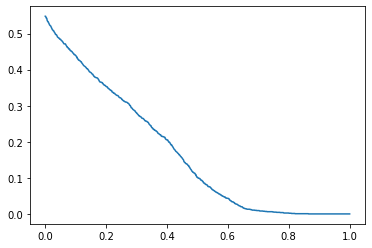

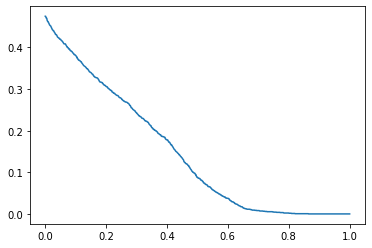

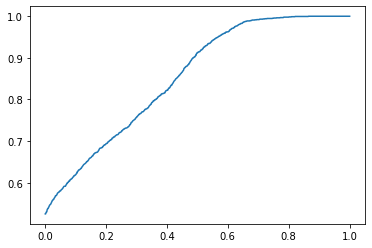

In [ ]:
pyplot.plot(iou_thresholds, yolo_precision)
pyplot.show()

pyplot.plot(iou_thresholds, yolo_recall)
pyplot.show()

pyplot.plot(iou_thresholds, yolo_missrate)
pyplot.show()

from scipy.io import savemat

mdic = {"yolo_threshold": iou_thresholds}
savemat("/content/yolo_results/iou_thresholds.mat", mdic)

mdic = {"yolo_precision": yolo_precision}
savemat("/content/yolo_results/yolo_precision.mat", mdic)

mdic = {"yolo_recall": yolo_recall}
savemat("/content/yolo_results/yolo_recall.mat", mdic)

mdic = {"yolo_missrate": yolo_missrate}
savemat("/content/yolo_results/yolo_missrate.mat", mdic)

mdic = {"yolo_f1": yolo_f1}
savemat("/content/yolo_results/yolo_f1.mat", mdic)